In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
daily_sales_numbers = [21,22,100,11,-15,35,36,26]

In [3]:
tf_dataset = tf.data.Dataset.from_tensor_slices(daily_sales_numbers)

In [4]:
tf_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [8]:
for sales in tf_dataset: ###or do a '.as_numpy_iterator()' here
    print(sales)

tf.Tensor(21, shape=(), dtype=int32)
tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(100, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(-15, shape=(), dtype=int32)
tf.Tensor(35, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32)
tf.Tensor(26, shape=(), dtype=int32)


In [9]:
for sales in tf_dataset:
    print(sales.numpy())

21
22
100
11
-15
35
36
26


In [12]:
for sales in tf_dataset.take(3):
    print(sales)

tf.Tensor(21, shape=(), dtype=int32)
tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(100, shape=(), dtype=int32)


#### Filtering

In [13]:
tf_dataset = tf_dataset.filter(lambda x: x>0)
for sales in tf_dataset:
    print(sales.numpy())

21
22
100
11
35
36
26


Map for indian currency

In [14]:
tf_dataset = tf_dataset.map(lambda x:x*72)
tf_dataset = tf_dataset.filter(lambda x: x>0)
for sales in tf_dataset:
    print(sales.numpy())

1512
1584
7200
792
2520
2592
1872


Batching

In [17]:
for sales_batch in tf_dataset.batch(2): ##size of batch is mentioned in the brackets
    print(sales_batch.numpy())

[1512 1584]
[7200  792]
[2520 2592]
[1872]


Tryna do it cleaner and with less lines

In [18]:
tf_dataset = tf.data.Dataset.from_tensor_slices(daily_sales_numbers)

tf_dataset = tf_dataset.filter(lambda x:x>0).map(lambda y:y*72).shuffle(2).batch(2)

In [20]:
for sales in tf_dataset.as_numpy_iterator(): ##size of batch is mentioned in the brackets
    print(sales)

[1512 1584]
[ 792 7200]
[2520 2592]
[1872]


Images Dataset

In [21]:
images_ds = tf.data.Dataset.list_files('images/*/*',shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: images/*/*'

### Plant Village project

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

1st element -> 32 images in one batch, 256*256 height and width, 3 channels RGB

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


#### Visualizing some of the images from the dataset

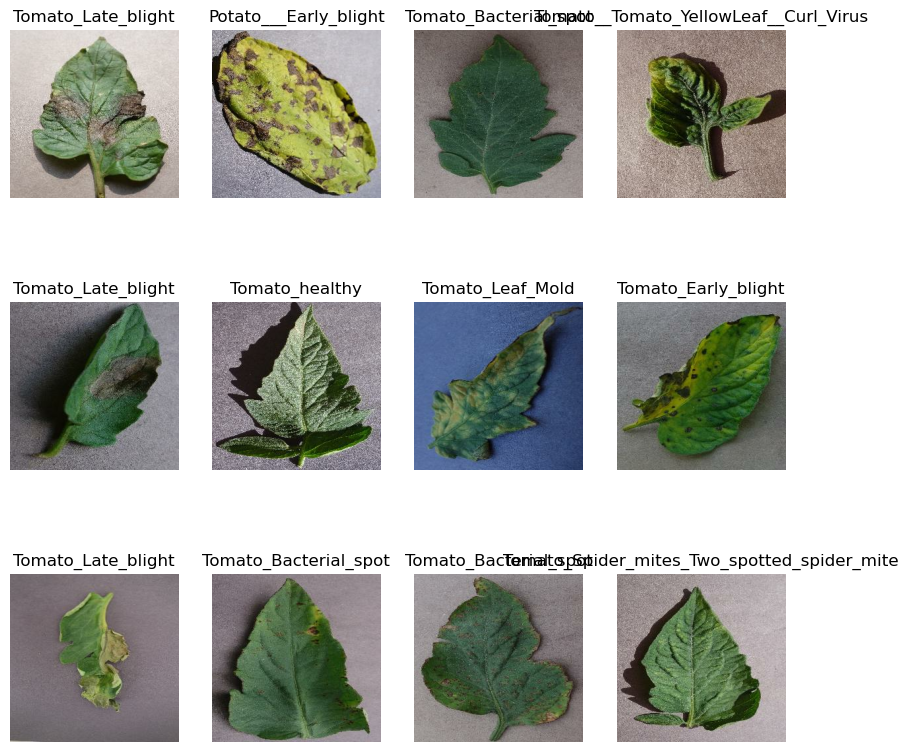

In [8]:
plt.figure(figsize=(10,10))

for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Training
Validation
Testing

In [9]:
len(dataset)

645

In [10]:
train_size=0.8
len(dataset)*train_size

516.0

In [11]:
train_ds = dataset.take(516)
len(train_ds)

516

In [12]:
test_ds = dataset.skip(516)
len(test_ds)

129

In [13]:
val_size = 0.1
len(dataset)*val_size

64.5

In [14]:
val_ds = dataset.take(64)
len(val_ds)

64

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

516

Resizing and normalizing

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

Applying it to train dataset

In [20]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y))

In [21]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### CNN MODEL

In [22]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

In [23]:
n_classes = 16

In [24]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

C:\Users\Divyansh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 16)                    │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,736 (1.06 MB)

 Trainable params: 278,736 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Compiler

In [26]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 237s 430ms/step - accuracy: 0.2501 - loss: 2.2626 - val_accuracy: 0.4316 - val_loss: 2.0490
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 230s 432ms/step - accuracy: 0.6323 - loss: 1.0785 - val_accuracy: 0.5347 - val_loss: 1.6389
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 233s 439ms/step - accuracy: 0.7441 - loss: 0.7615 - val_accuracy: 0.5879 - val_loss: 1.5506
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 227s 426ms/step - accuracy: 0.7891 - loss: 0.6211 - val_accuracy: 0.7578 - val_loss: 0.7728
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 422ms/step - accuracy: 0.8369 - loss: 0.4769 - val_accuracy: 0.7864 - val_loss: 0.6338
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 226s 425ms/step - accuracy: 0.8572 - loss: 0.4097 - val_accuracy: 0.8745 - val_loss: 0.3696
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 220s 415ms/step - accuracy: 0.8881 - loss: 0.3269 - val_accuracy: 0.8799 - val_loss: 0.3623
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 421ms/step - accuracy: 0.8870 -

In [30]:
scores = model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - accuracy: 0.9437 - loss: 0.1889


In [31]:
scores

[0.18765783309936523, 0.9447115659713745]

loss and accuracy values

Plotting the Accuracy and Loss Curves

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

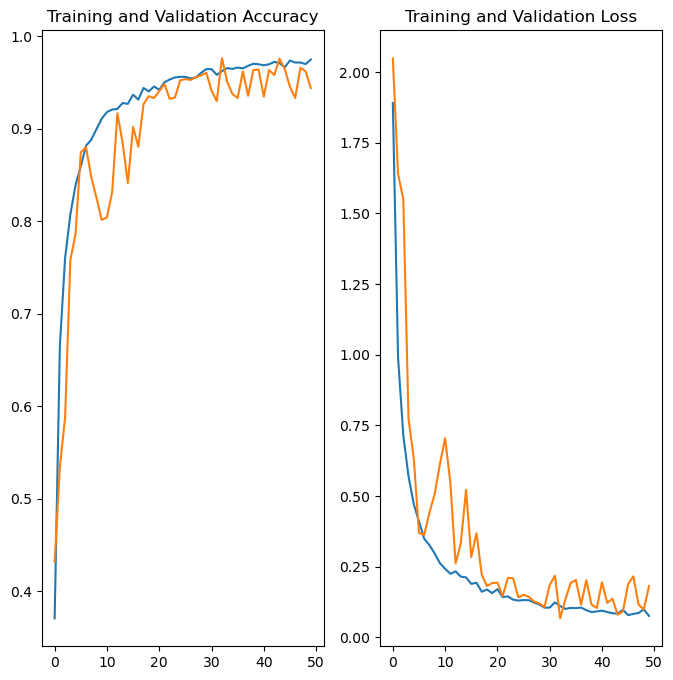

In [39]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')

Testing it on a sample image

first image to predict


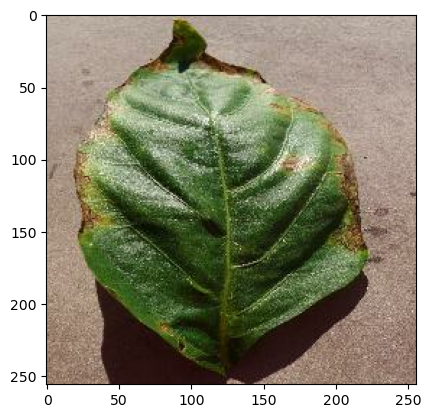

In [42]:
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)

first image to predict
actual label Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
predicted label:  Tomato_healthy


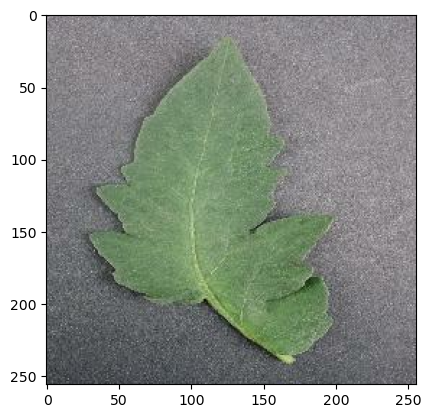

In [48]:
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual label',class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

